## Setup autoreload, warnings and helper functions

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, Markdown
def print_heading(string):
    display(Markdown(f"# {string}"))
def print_subheading(string):
    display(Markdown(f"## {string}"))

## Set the visibility of cuda devices (in case your system contains more than one)

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


## Imports

In [3]:
%matplotlib inline
from config import config
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import zipfile
import tensorflow as tf
import wget
import pickle
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from torchvision.datasets.utils import download_url
from datasets import SimpleDataset

from tools import apply_pipeline, crop_step, curry, apply_pipeline_cocodataset, get_save_step
from tonemapping.tonemapping import tonemap, tonemap_step
from segmentation.segmentation import segment
from pattern_extraction.extract_pattern import extract_pattern
from reidentification.identify import encode_single, encode_pipeline, create_database, identify, identify_single, encode_dataset
from reidentification.visualisation import visualise_match
from simple_database import DBDatabase

/veikka_immonen/env/norppa/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-15 18:40:24.443660: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-15 18:40:26.198923: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-15 18:40:26.278728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-04-15 18:40:26.278787: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-15 18:40:26.28250

## Create a configuration file.
You can change the default parameters in config.py

In [4]:
cfg = config()

/veikka_immonen/work/NORPPA/reidentification/hesaff_pytorch/architectures.py:71: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.9)
/veikka_immonen/work/NORPPA/reidentification/hesaff_pytorch/architectures.py:73: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0.01)
2023-04-15 18:40:33.585244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:83:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-04-15 18:40:33.585937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-04-15 18:40:33.586043: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-15 18:40:33.586221: I tensorflow/core/com

## Path to the dataset

In [5]:
cfg["dataset_dir"] = "/veikka_immonen/work/data/dataset-0520/segmented/query/"
cfg["dataset_db_dir"] = "/veikka_immonen/work/data/dataset-0520/segmented/database"

dataset_dir = Path(cfg["dataset_dir"])
dataset_db_dir = Path(cfg["dataset_db_dir"])

print(f'SealID dataset is ready')

SealID dataset is ready


## Create dataset variables

In [6]:
query_dataset = SimpleDataset(dataset_dir)

print(len(query_dataset))

img_data = query_dataset[3]
print(img_data)

1650
(<PIL.Image.Image image mode=RGB size=1501x593 at 0x7F1030E8AB50>, {'class_id': 'phs026', 'file': '/veikka_immonen/work/data/dataset-0520/segmented/query/phs026/IM000306.JPG.result.png', 'dataset_dir': PosixPath('/veikka_immonen/work/data/dataset-0520/segmented/query')})


## Show an image from the dataset

# Input image

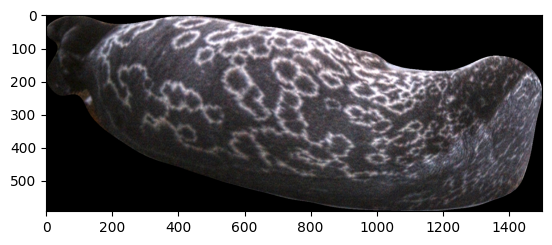

In [7]:
img, label = img_data

print_heading("Input image")
plt.imshow(img)
plt.show()

## Extract pattern

In [8]:
extract_pattern_step = curry(extract_pattern, model=cfg["unet"])
#pattern_query_dataset = apply_pipeline_cocodataset(query_dataset, [crop_step,extract_pattern_step], verbose=True)

## Encode dataset

In [9]:
#encoded_dataset = encode_dataset(pattern_query_dataset, cfg)
#print(len(encoded_dataset))
#print("Encoded dataset")

## Save intermediate steps id needed

In [10]:

#with open("/veikka_immonen/work/data/encoded_sealid.pickle", 'wb') as f_file:
    #pickle.dump(encoded_dataset, f_file)

In [11]:

with open("/veikka_immonen/work/data/encoded_sealid.pickle", 'rb') as f_file:
    encoded_dataset = pickle.load(f_file)

## Load database for testing
This example uses a very simple database implemented as a Python class. 

In [12]:
# db_database = DBDatabase("norppa", cfg)

db_dataset = SimpleDataset(dataset_db_dir)
pattern_db_dataset = apply_pipeline_cocodataset(db_dataset, [crop_step,extract_pattern_step], verbose=True)
db_database = encode_dataset(pattern_db_dataset, cfg)

# print(len(db_database.get_fisher_vectors()))
print(len(db_database))
print("Created a test database")

2023-04-15 18:40:38.624697: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-15 18:40:38.644006: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz
2023-04-15 18:40:38.943642: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-15 18:40:39.702220: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8401
2023-04-15 18:40:40.685736: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-15 18:40:40.687232: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


Completed 1/430 images
Completed 2/430 images
Completed 3/430 images
Completed 4/430 images
Completed 5/430 images
Completed 6/430 images
Completed 7/430 images
Completed 8/430 images
Completed 9/430 images
Completed 10/430 images
Completed 11/430 images
Completed 12/430 images
Completed 13/430 images
Completed 14/430 images
Completed 15/430 images
Completed 16/430 images
Completed 17/430 images
Completed 18/430 images
Completed 19/430 images
Completed 20/430 images
Completed 21/430 images
Completed 22/430 images
Completed 23/430 images
Completed 24/430 images
Completed 25/430 images
Completed 26/430 images
Completed 27/430 images
Completed 28/430 images
Completed 29/430 images
Completed 30/430 images
Completed 31/430 images
Completed 32/430 images
Completed 33/430 images
Completed 34/430 images
Completed 35/430 images
Completed 36/430 images
Completed 37/430 images
Completed 38/430 images
Completed 39/430 images
Completed 40/430 images
Completed 41/430 images
Completed 42/430 images
C

  0%|                                                                                                                                              | 0/430 [00:00<?, ?it/s]/veikka_immonen/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/veikka_immonen/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|████████████████████████████████████████████████████████████████████████████████████████

Calculating PCA
Getting encoding parameters...
Encoding...
430
Created a test database


## Perform re-identification

$\large \Delta \in [0.15, 0.25]$

$\large a \in \mathbb{R}$

$\huge E(p, d_c) = d_c (1-p)^a$

Smaller value = better

Other estimators to try:

$\huge E(d_c, \omega) = d_c (1-\omega)^a$

$\huge E(d_c, n_\text{in}) = d_c^{n_\text{in}}$

$\huge E(d_c, n_\text{in}) = n_\text{in}^{-1}$


In [13]:
#import cv2
#import numpy as np
#from geometric import geometric
#cfg["topk"] = 100


#est_cfg = {
 #   "method": cv2.RANSAC,
 #   "max_reproj_err": 0.05,
 #   "max_iters": 5000,
 #   "estimator": lambda d, mask: d ** np.sum(mask)
#}

#identification_results = identify(encoded_dataset, db_database, cfg, est_cfg=est_cfg)


## Get data

In [ ]:
import cv2
import numpy as np
from geometric import geometric

cfg["topk"] = 430

est_cfg = {
    "method": cv2.RANSAC,
    "max_iters": 5000,
    "max_reproj_err": .05,
    "estimator": lambda d, mask: d ** np.sum(mask)
}
    
identification_results = identify(encoded_dataset, db_database, cfg, est_cfg=est_cfg)


  1%|▍                                            | 14/1650 [03:05<5:35:42, 12.31s/it]

## Calculate the accuracy

In [99]:
db_labels = np.array([[x['db_label']['class_id'] for x in y[0]] for y in identification_results])
q_labels = np.array(query_dataset.get_labels())

hits = (db_labels.T == q_labels).T

_ = print([i for i, A in enumerate(hits) if not A[0]])

probs = [sum((np.sum(hits[:, :j+1], axis=1) > 0)) / len(q_labels)
             for j in range(430)]

print(f"err={est_cfg['max_reproj_err']:.4f},max_iters={est_cfg['max_iters']}")
_ = [print(f"{100 * p:.6f}", end = " ") for p in probs[:20]]
print()

[1, 6, 9, 21, 32, 38, 45, 50, 52, 53, 55, 63, 64, 69, 71, 74, 76, 77, 78, 80, 91, 93, 105, 107, 111, 113, 116, 117, 120, 128, 139, 148, 154, 159, 170, 180, 181, 183, 184, 186, 189, 190, 194, 198, 201, 204, 205, 208, 209, 213, 217, 262, 265, 269, 271, 274, 298, 300, 304, 308, 310, 312, 313, 317, 318, 319, 320, 323, 326, 327, 330, 331, 333, 337, 338, 339, 341, 342, 343, 344, 346, 347, 352, 354, 355, 358, 361, 363, 366, 368, 373, 374, 381, 382, 388, 394, 410, 413, 415, 420, 423, 424, 425, 428, 432, 435, 450, 452, 453, 481, 502, 504, 509, 511, 512, 517, 518, 521, 522, 528, 531, 532, 537, 551, 558, 564, 574, 576, 577, 581, 583, 585, 589, 595, 596, 600, 602, 604, 605, 609, 610, 613, 614, 616, 618, 619, 625, 626, 628, 629, 634, 637, 641, 642, 644, 651, 654, 660, 661, 668, 677, 681, 687, 693, 694, 719, 722, 724, 726, 731, 741, 742, 743, 745, 747, 752, 754, 761, 781, 796, 810, 811, 818, 819, 820, 827, 832, 836, 841, 848, 852, 853, 857, 858, 859, 865, 866, 873, 875, 880, 882, 892, 895, 898, 899,

## Accuracy after geometric verification

## Visualise re-identification results

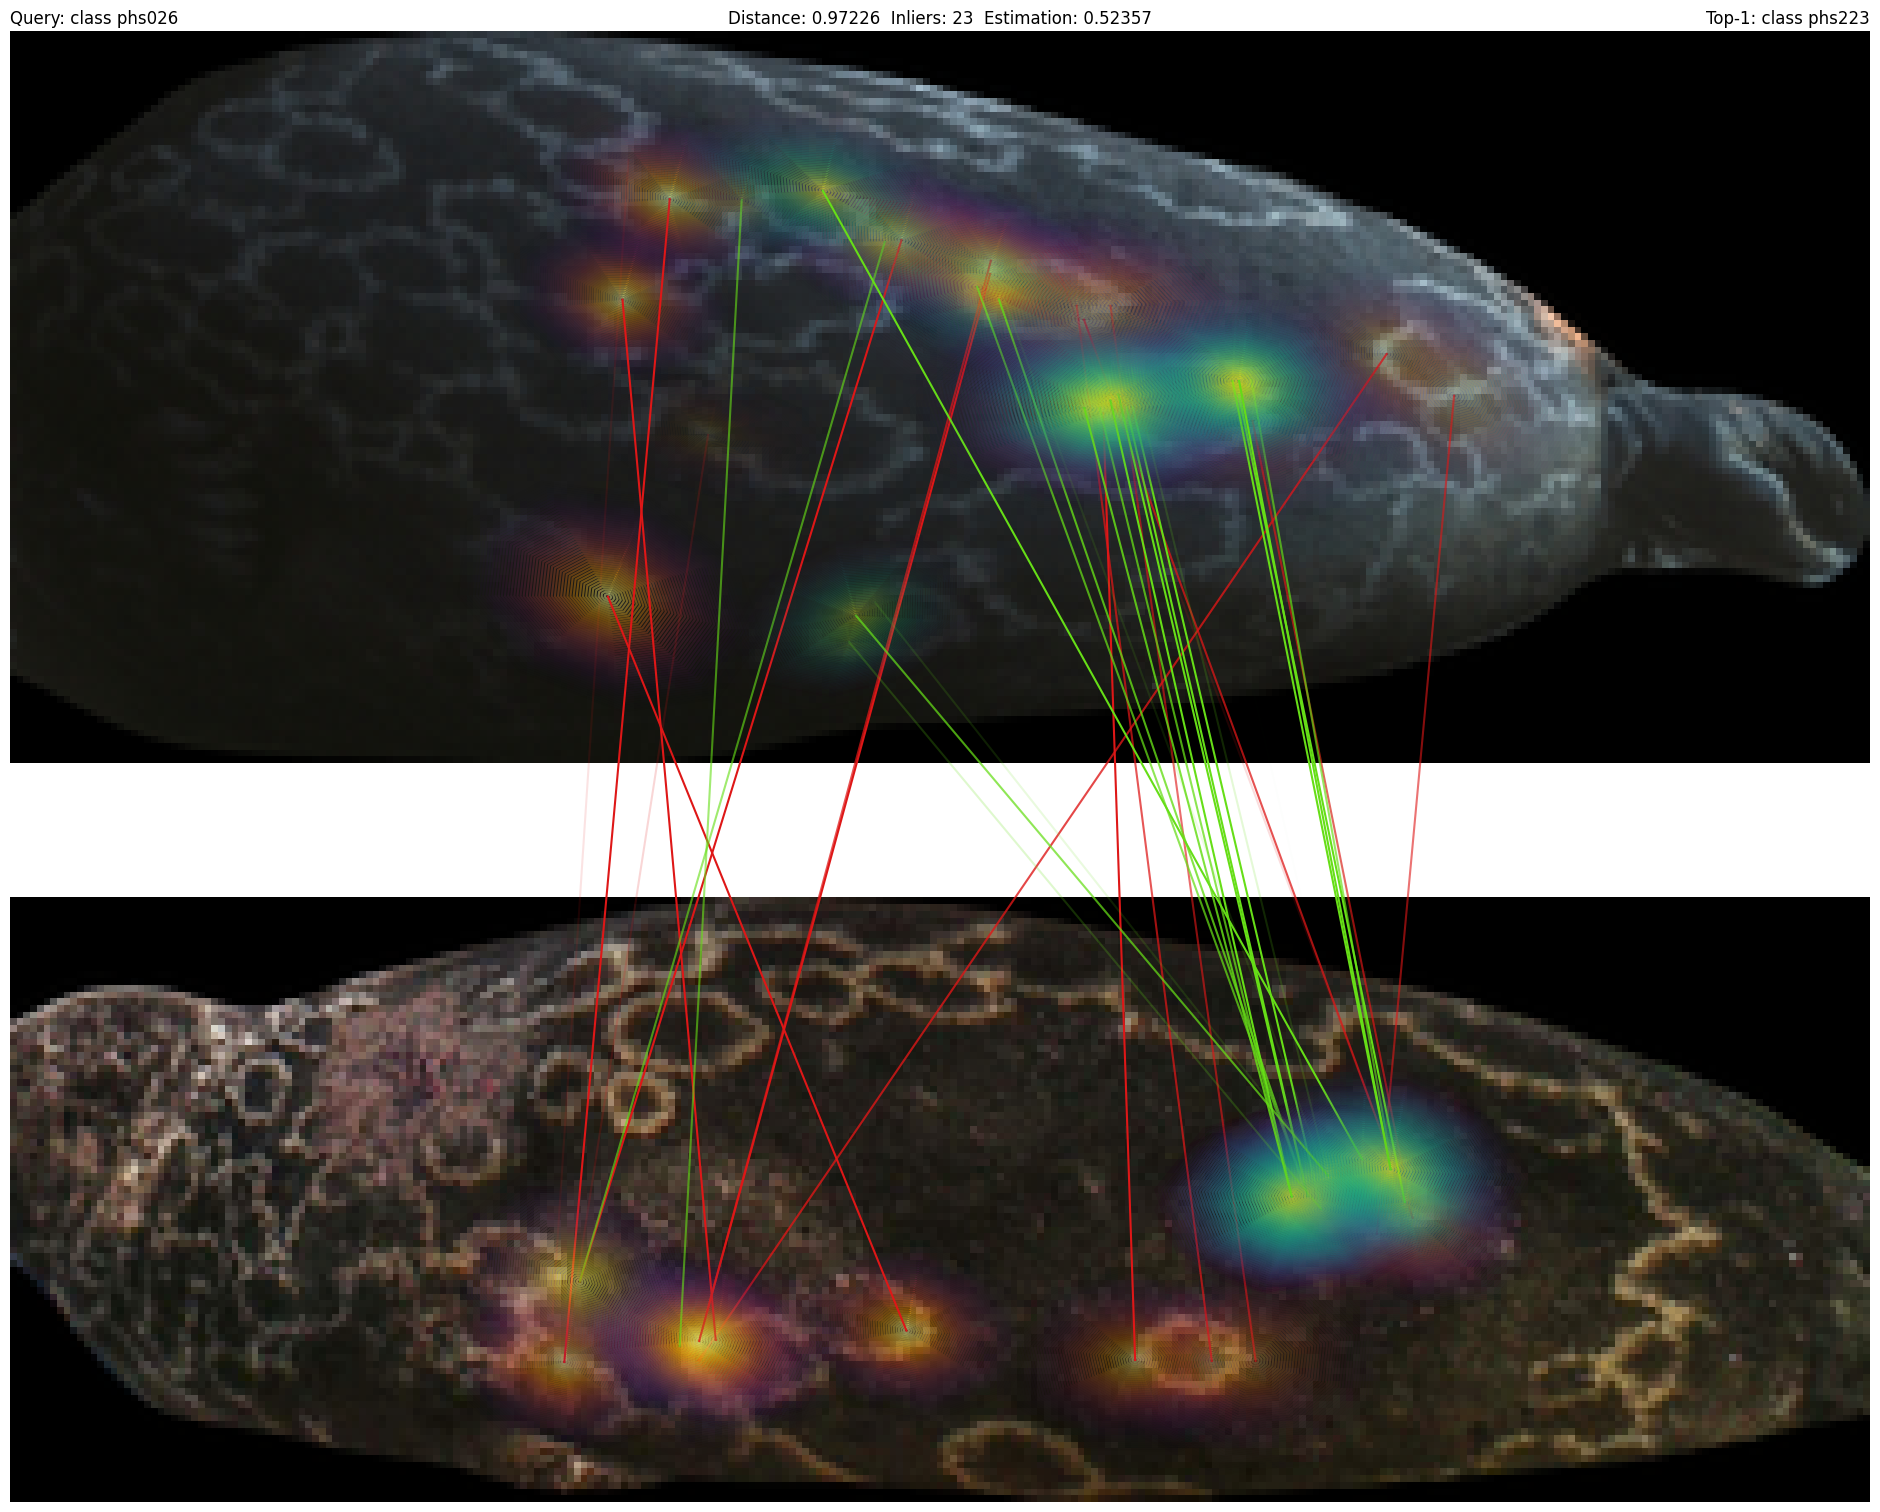

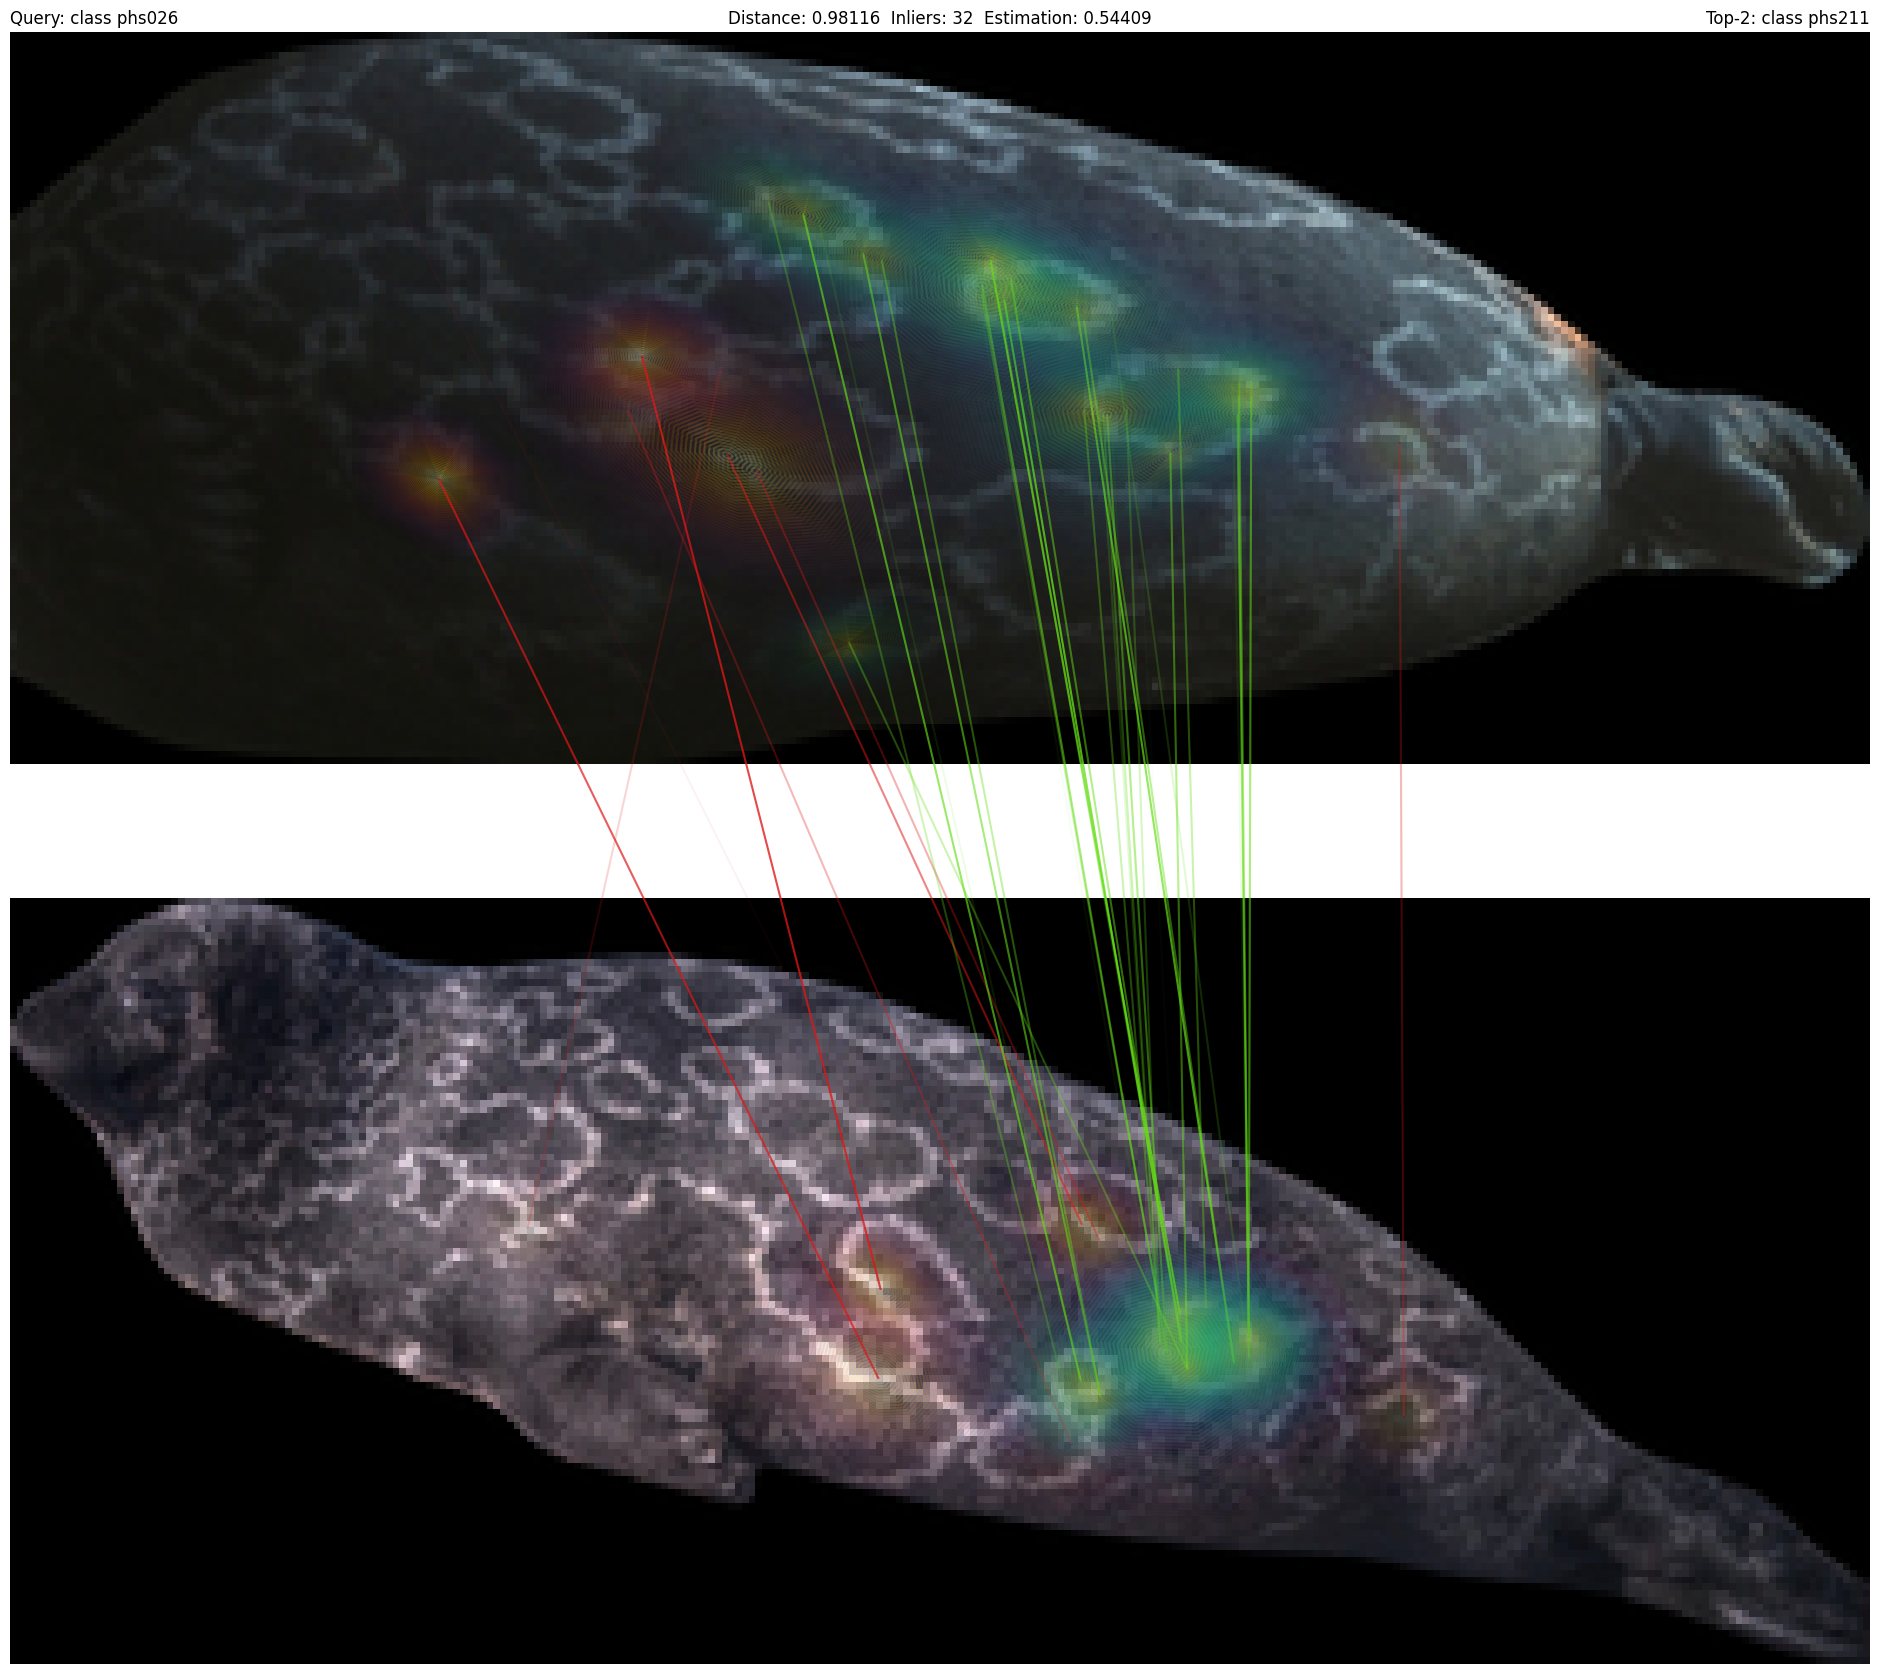

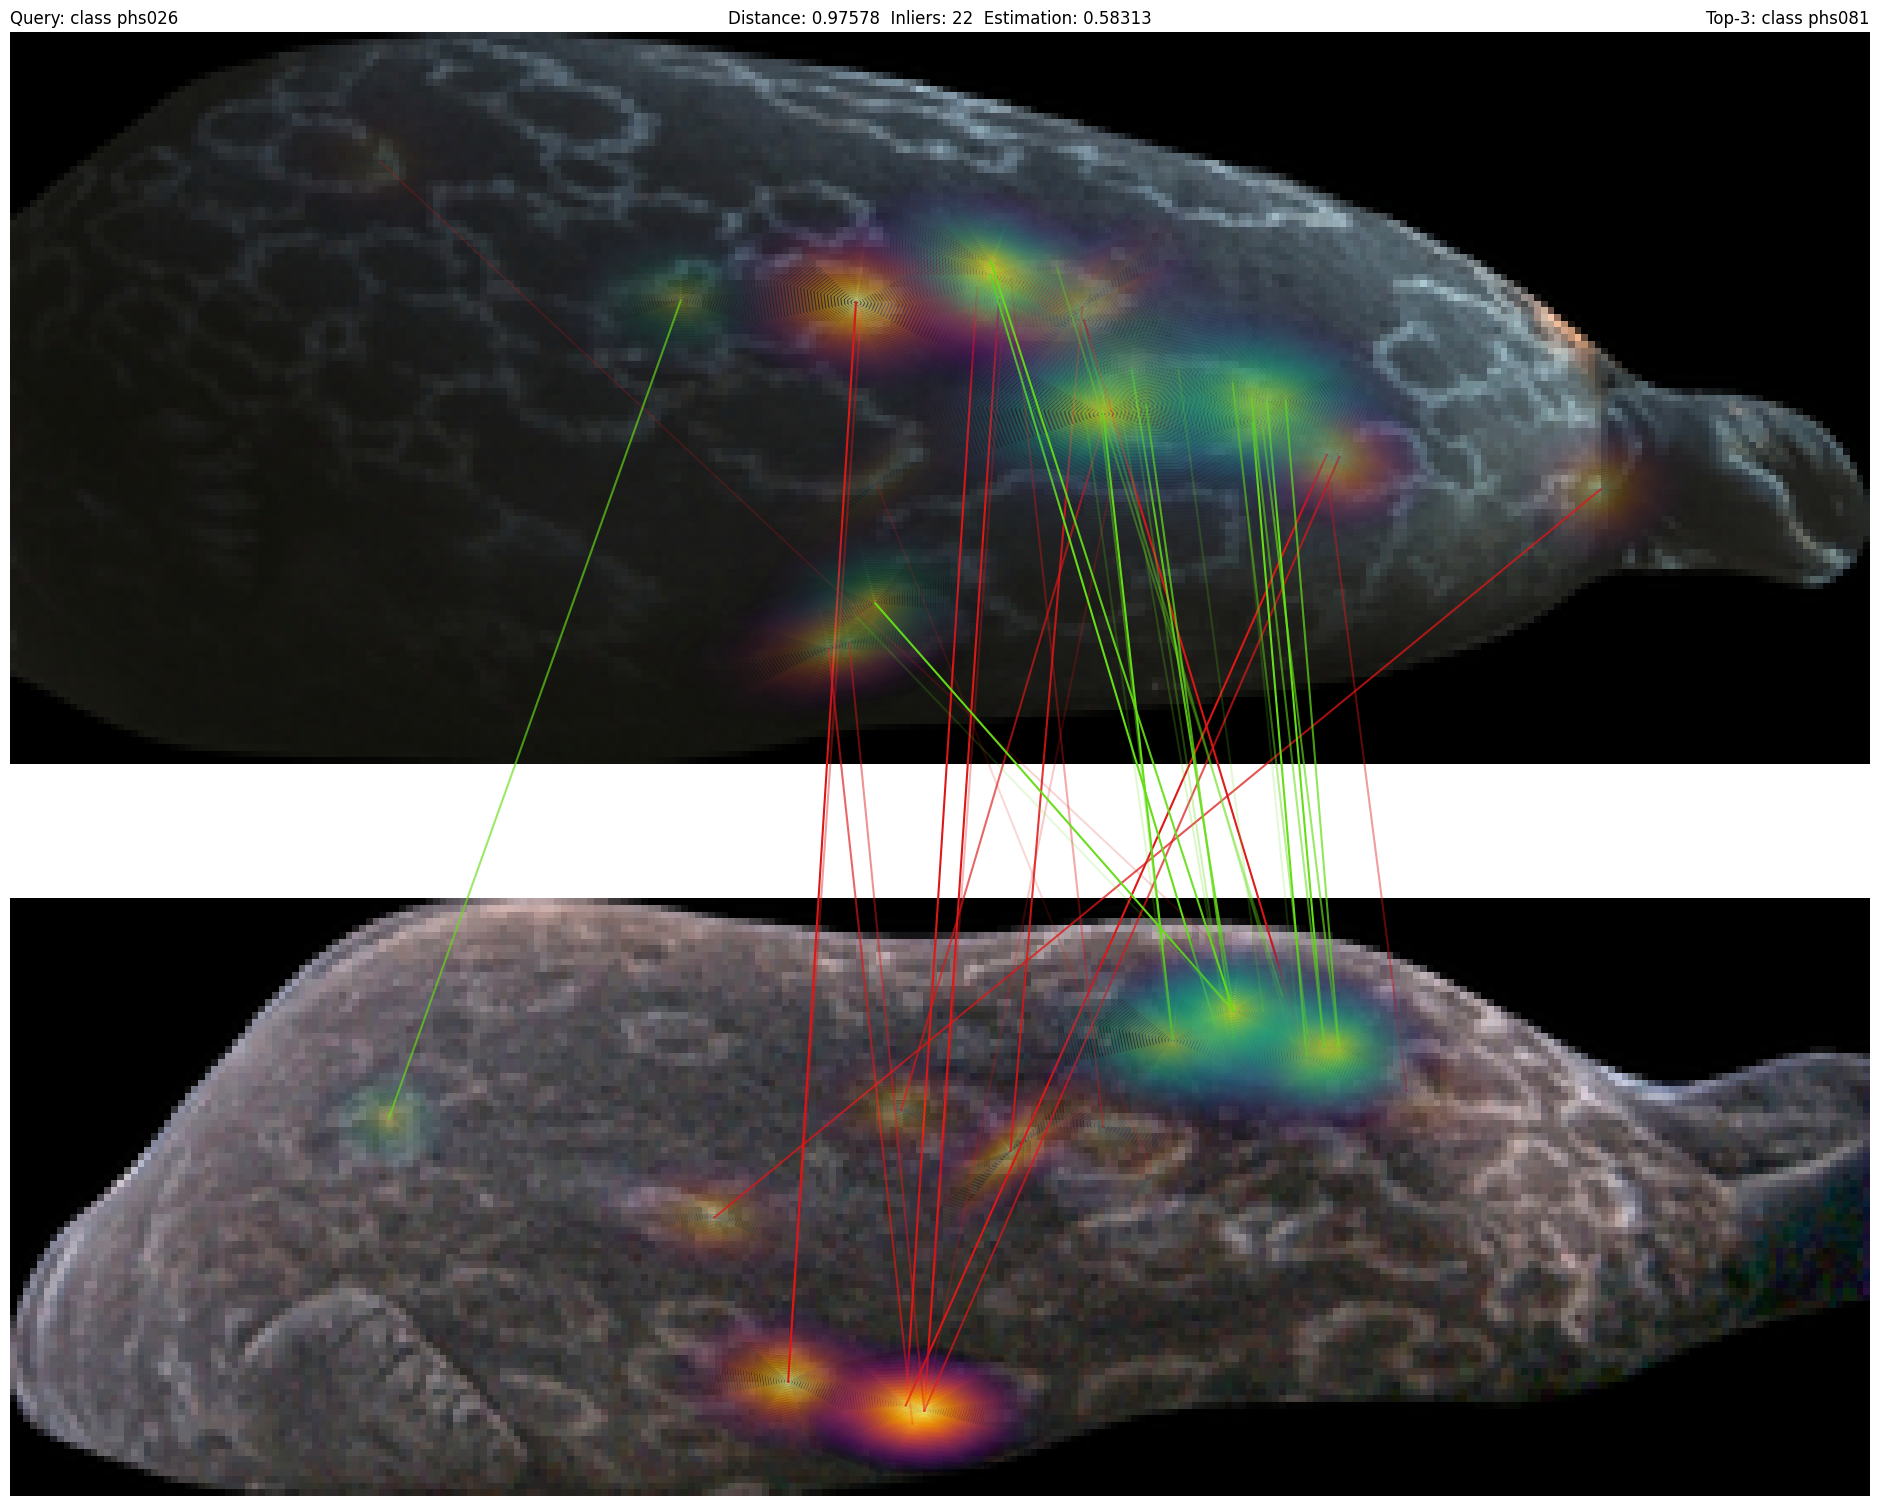

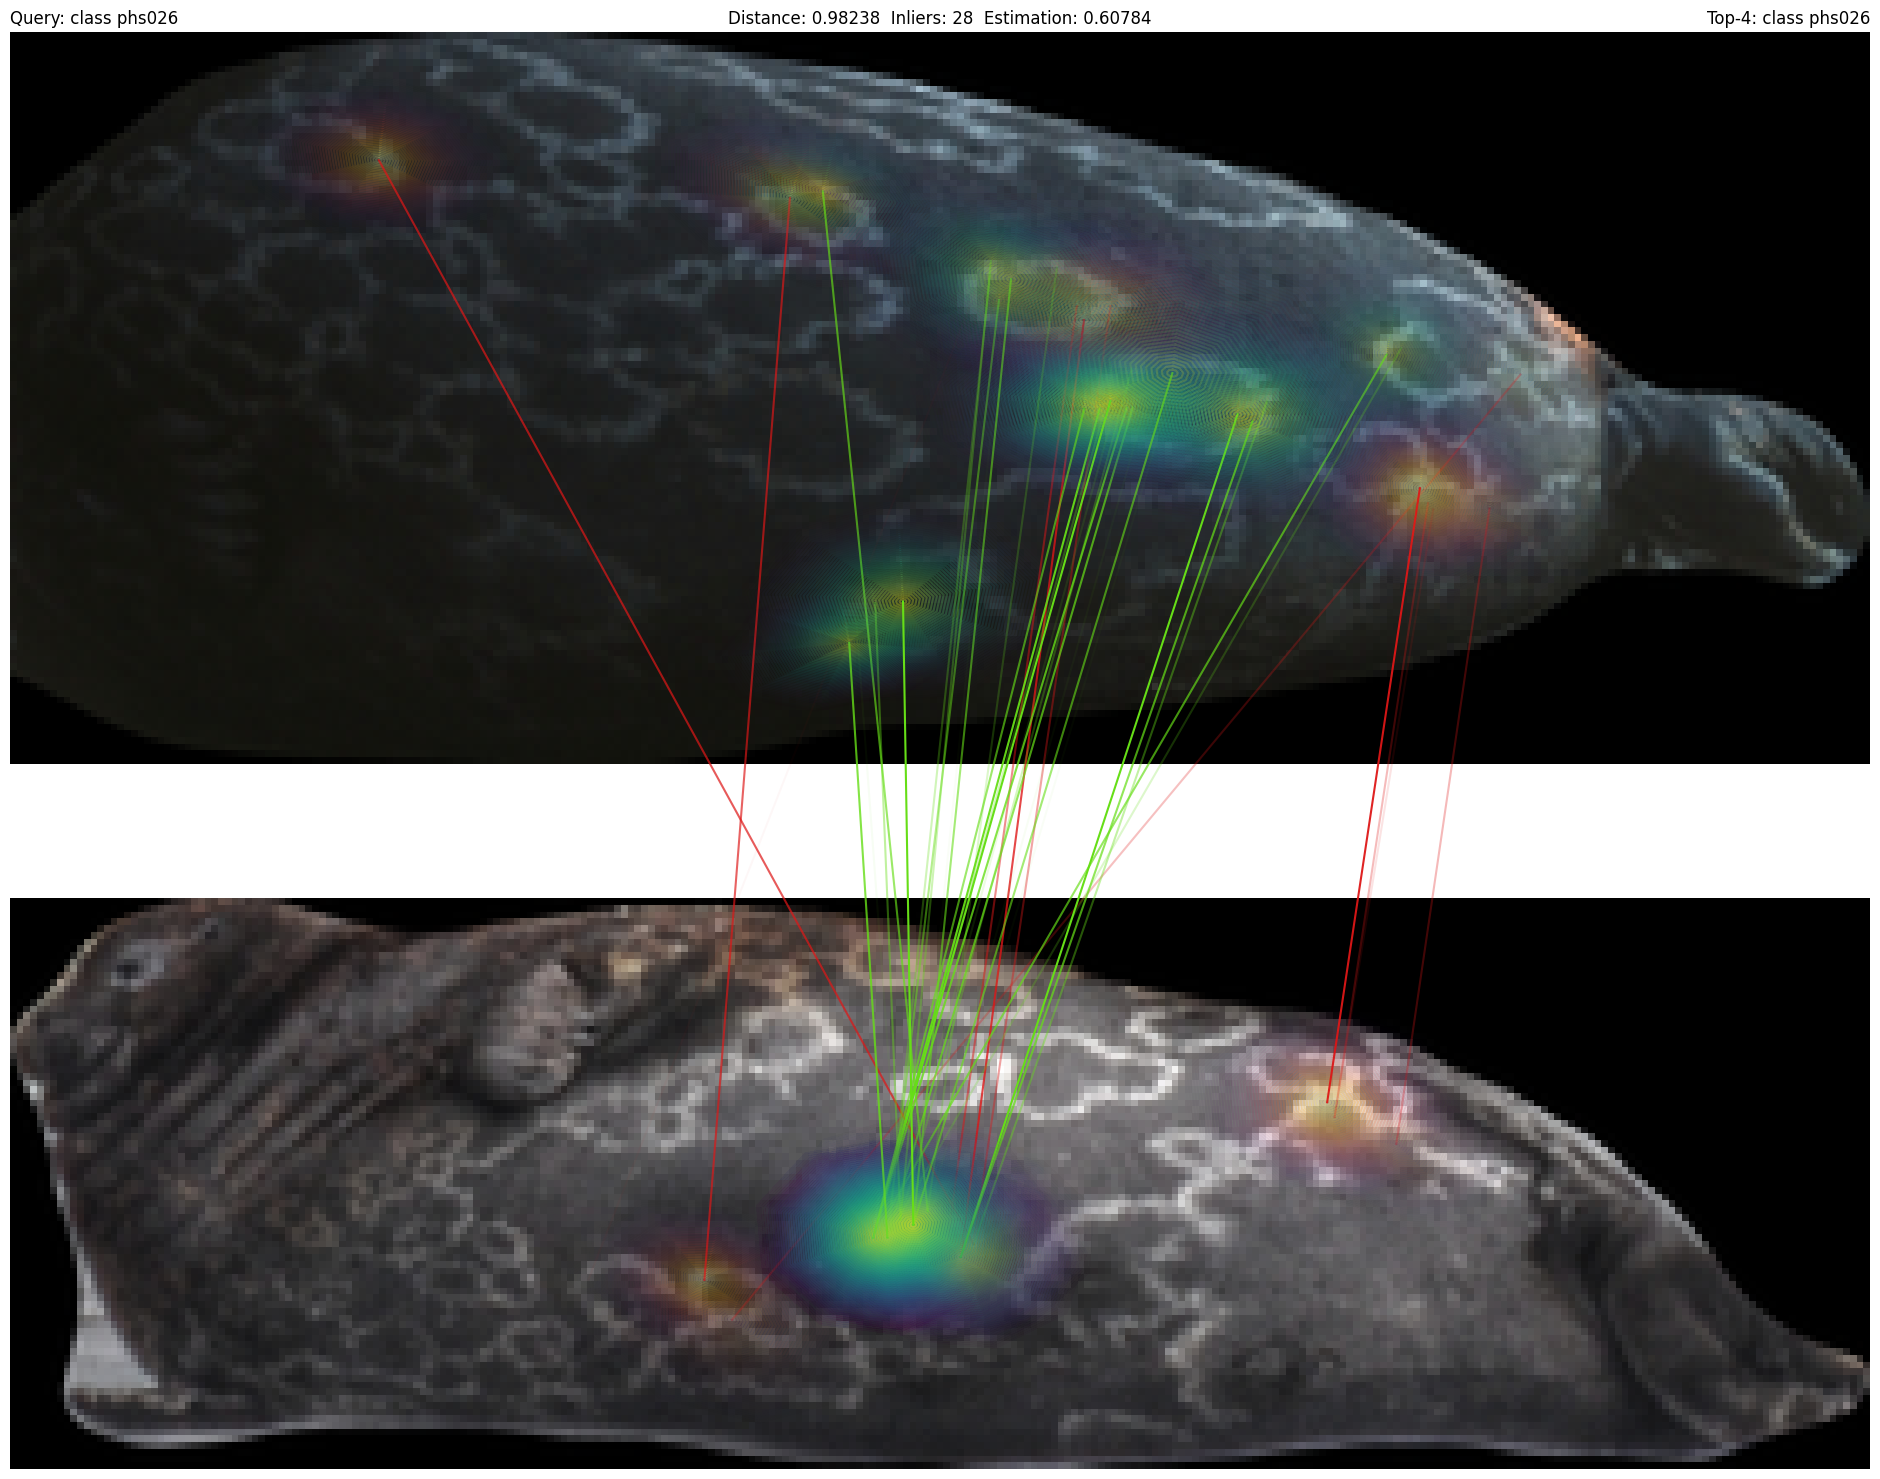

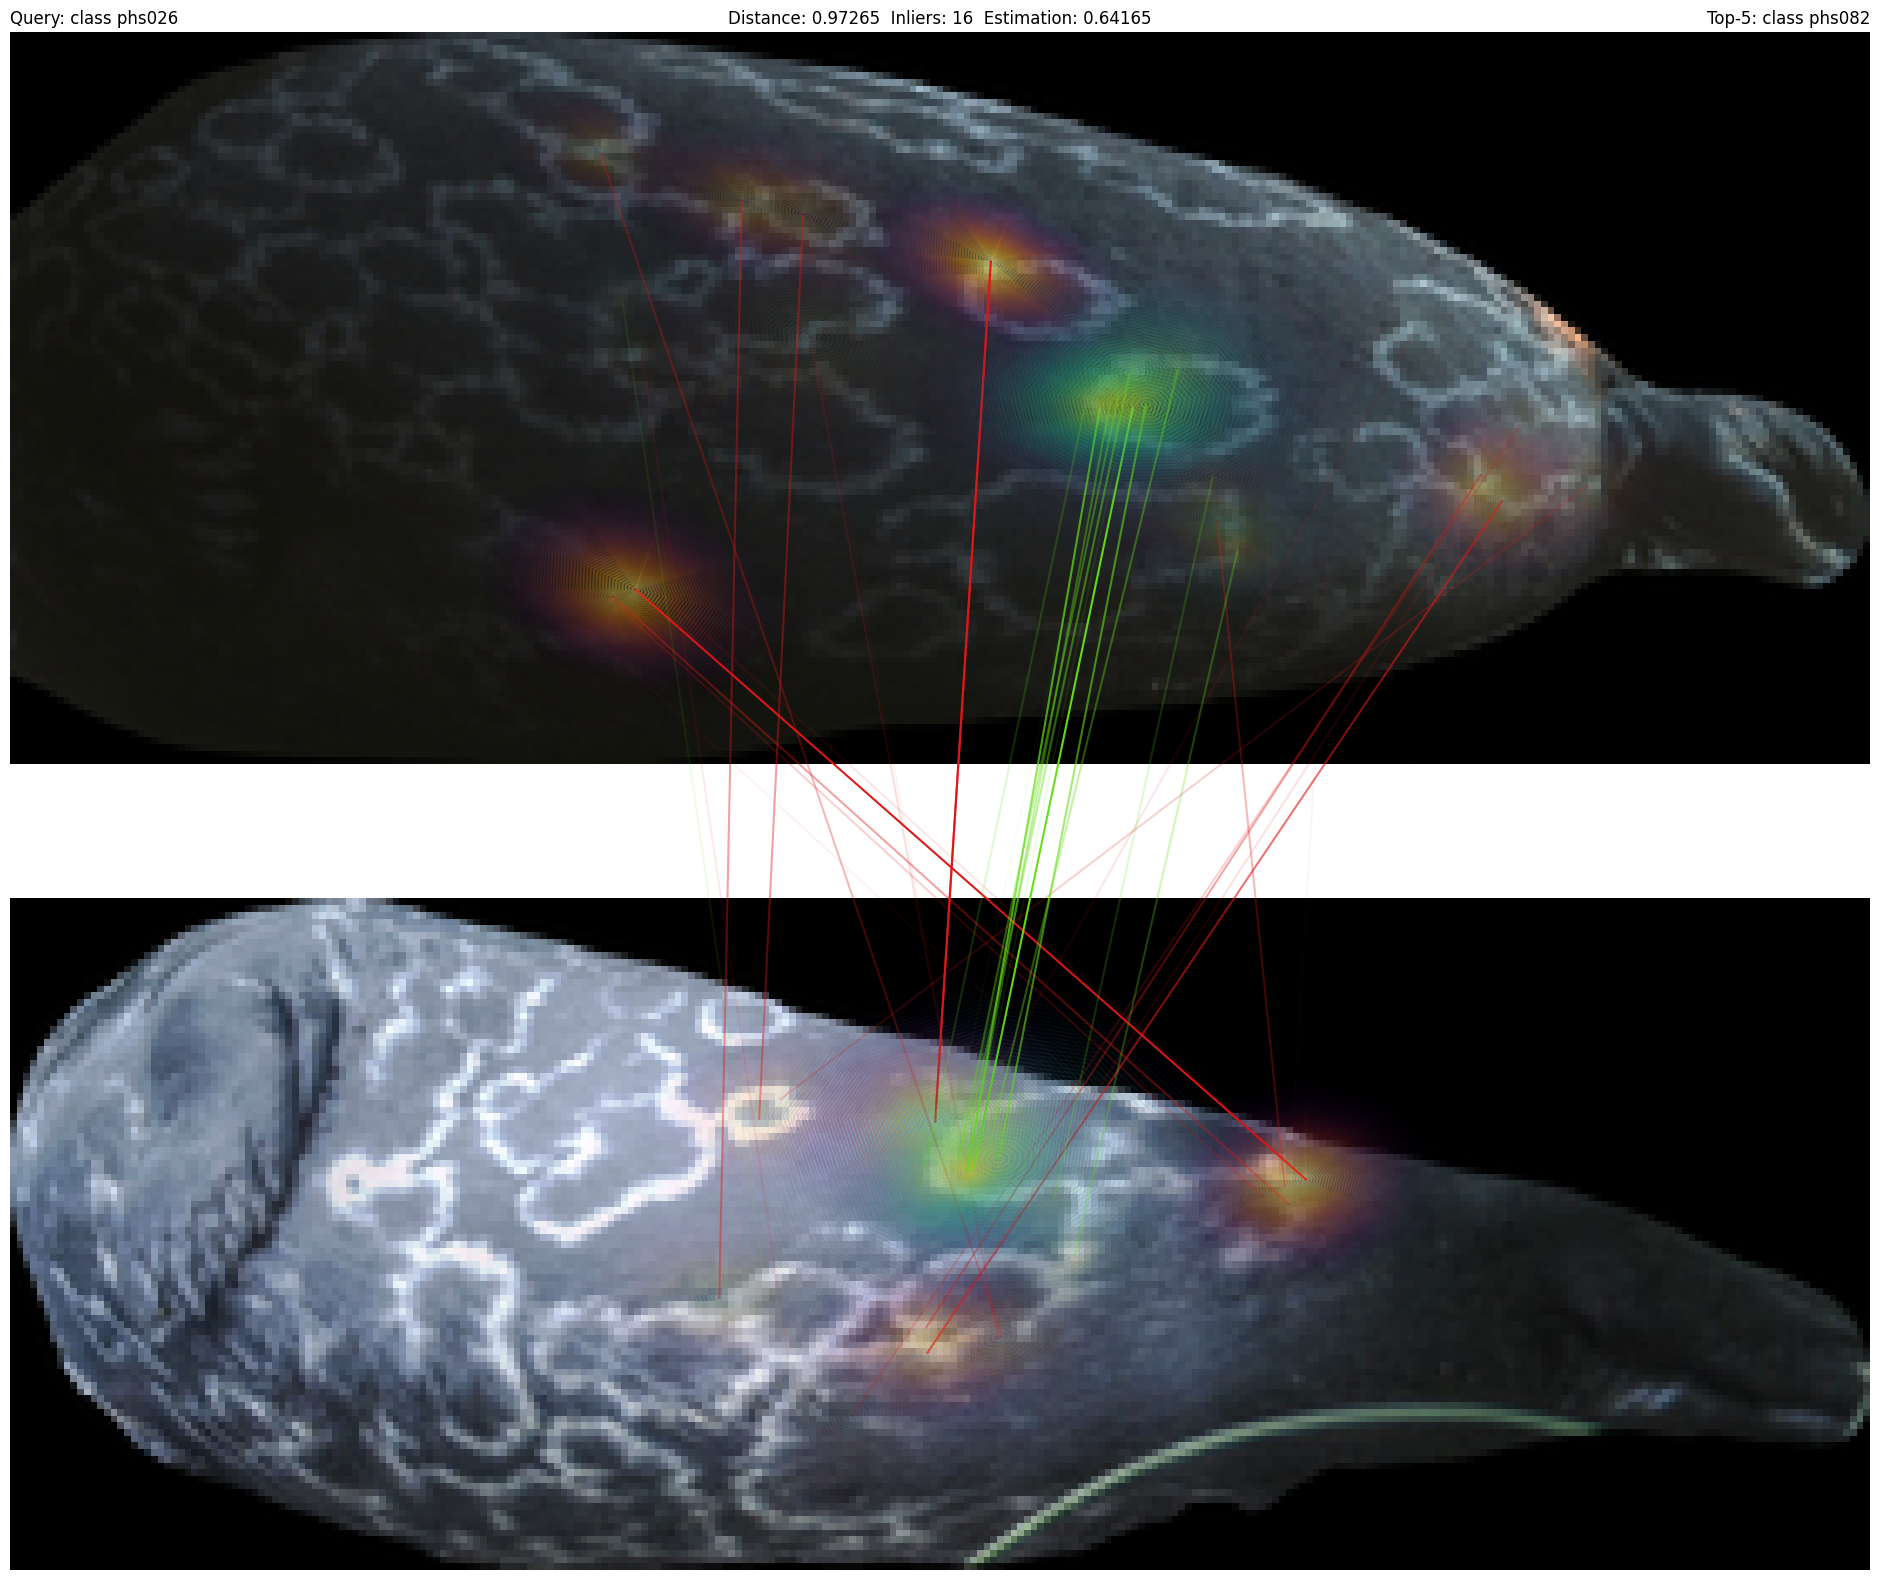

In [95]:
# indices:
# 90 no outliers ??
# 100 missed inliers
# 120 incorrect -> correct
# 125 challengin case
# 130 easy case
# 131 missed matches (deformable body)
# 133 missed matches
# 150 perfect match
# 190 incorret -> incorrect (correct is top3)
# 200 missed matches


cfg["topk"] = 5
_ = visualise_match(identification_results[6], cfg)